In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# Parameter dari data (parameter awal)
N = 279798049  # Total populasi
alpha = 0.0000455  # Tingkat kelahiran harian
mu = 0.0000187  # Tingkat kematian alami
beta1 = 0.4  # Estimasi tingkat infeksi untuk S
beta2 = 0.1  # Estimasi tingkat infeksi untuk V
beta3 = 0.5  # Estimasi tingkat infeksi untuk Vm
gamma1 = 0.653  # Efektivitas vaksin
gamma2 = 0.01  # Pertumbuhan populasi misinformed
gamma3 = 0.0714  # Tingkat pemulihan
gamma = 0.00476  # Kehilangan kekebalan (6-8 bulan)

# Populasi awal
I0 = 520000  # Kasus aktif awal
R0 = 508000  # Kasus sembuh awal
V0 = 161861222  # Populasi divaksin
Vm0 = 0.27 * N  # Populasi misinformed
S0 = N - I0 - R0 - V0 - Vm0  # Sisanya adalah populasi rentan

# Waktu simulasi (dalam hari)
t_start = 0
t_end = 365  # Simulasi 1 tahun
t_eval = np.linspace(t_start, t_end, 365)  # Titik evaluasi

In [3]:
# Model SVIR
def svir_model(t, y, beta1, beta2, beta3):
    S, V, Vm, I, R = y
    dSdt = alpha * N - mu * S - beta1 * S * I / N - gamma1 * S
    dVdt = gamma1 * S - beta2 * V * I / N - gamma * V
    dVmdt = gamma2 * S - beta3 * Vm * I / N
    dIdt = beta1 * S * I / N + beta2 * V * I / N + beta3 * Vm * I / N - gamma3 * I - mu * I
    dRdt = gamma3 * I - gamma * R - mu * R
    return [dSdt, dVdt, dVmdt, dIdt, dRdt]

# Fungsi untuk simulasi
def simulate_svir(t, beta1, beta2, beta3):
    y0 = [S0, V0, Vm0, I0, R0]
    solution = solve_ivp(
        svir_model, [t[0], t[-1]], y0, t_eval=t, args=(beta1, beta2, beta3)
    )
    return solution.y[3]  # Kembalikan hanya nilai kasus aktif (I)


In [4]:


# Data dummy (misalnya, data kasus aktif harian dengan noise)
np.random.seed(42)  # Untuk reproduktibilitas
I_data_dummy = simulate_svir(t_eval, 0.4, 0.1, 0.5) + np.random.normal(0, 50000, size=len(t_eval))

# Fungsi fitting
def fitting_func(t, beta1, beta2, beta3):
    return simulate_svir(t, beta1, beta2, beta3)

# Fitting parameter menggunakan curve_fit
popt, pcov = curve_fit(fitting_func, t_eval, I_data_dummy, bounds=(0, [1.0, 1.0, 1.0]))
beta1_fit, beta2_fit, beta3_fit = popt

# Hasil fitting
print("Parameter hasil fitting:")
print(f"beta1: {beta1_fit}")
print(f"beta2: {beta2_fit}")
print(f"beta3: {beta3_fit}")

Parameter hasil fitting:
beta1: 0.3865271054363271
beta2: 0.09996695383015039
beta3: 0.500296090946184


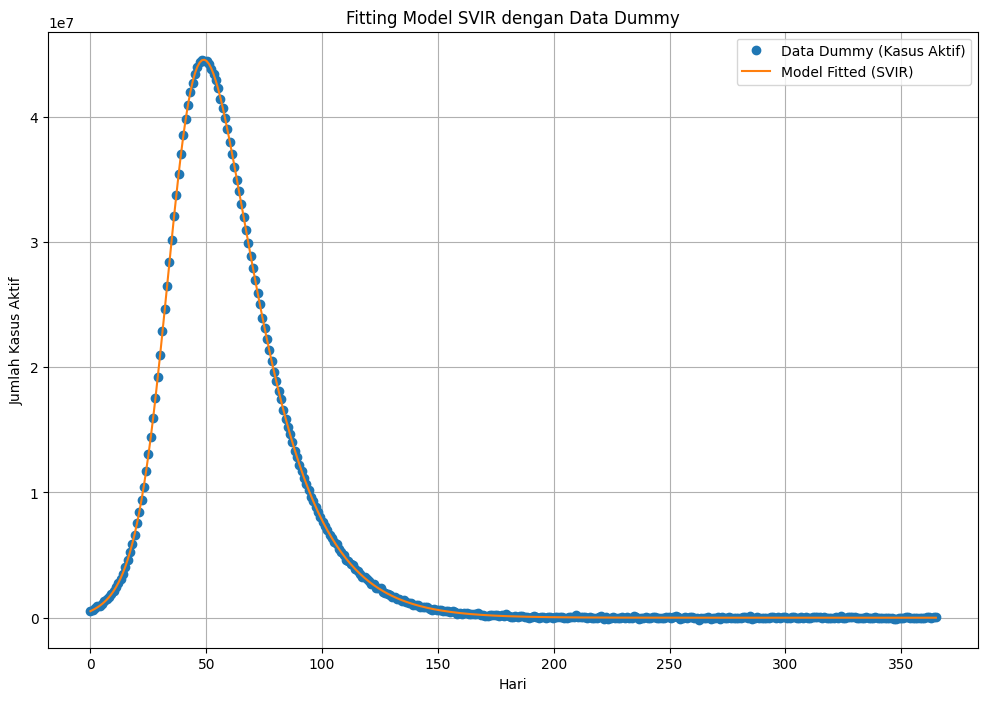

In [5]:
# Plot hasil
plt.figure(figsize=(12, 8))
plt.plot(t_eval, I_data_dummy, 'o', label="Data Dummy (Kasus Aktif)")
plt.plot(t_eval, simulate_svir(t_eval, *popt), '-', label="Model Fitted (SVIR)")
plt.title('Fitting Model SVIR dengan Data Dummy')
plt.xlabel('Hari')
plt.ylabel('Jumlah Kasus Aktif')
plt.legend()
plt.grid()
plt.show()
